# Shallow Water Equation

## Load packages

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from utils import *

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


## Solve the 1D SWE using the Finite Volume Method with a Riemann solver



## Boundary conditions

In [48]:
def subplot(h_hist, idx, L, N, save = False, filename = None):
    idx1, idx2, idx3 = idx
    y_max = max([h_hist[i].max() for i in idx]) + 0.1 # Determine the maximum y value among the selected indices
    y_min = min([h_hist[i].min() for i in idx]) - 0.1 # Determine the minimum y value among the selected indices

    plt.figure(figsize=(17, 5))

    plt.subplot(1, 3, 1)
    plt.plot(np.linspace(0, L, N), h_hist[idx1])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx1}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(np.linspace(0, L, N), h_hist[idx2])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx2}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(np.linspace(0, L, N), h_hist[idx3])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx3}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)
    plt.grid()

    if save:
        plt.savefig(filename)



In [49]:
def roe_solver(hL, huL, hR, huR, g=9.81, lim_func = minmod):
    # Calculate Roe averages
    h_tilde = (hL + hR) / 2
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))

    c = np.sqrt(g * h_tilde)

    # Calculate eigenvalues and eigenvectors
    lambda1 = u_tilde - c
    lambda2 = u_tilde + c
    R1 = np.array([1, lambda1])
    R2 = np.array([1, lambda2])

    # Compute wave strengths
    dh = hR - hL
    du = huR/hR - huL/hL
    alpha1 = 0.5*(dh - h_tilde/c * du)
    alpha2 = 0.5*(dh + h_tilde/c * du)

    # Compute fluxes
    F_L = np.array([huL, huL**2 / hL + 0.5 * g * hL**2])
    F_R = np.array([huR, huR**2 / hR + 0.5 * g * hR**2])

    # Compute the Roe flux
    F = 0.5 * (F_L + F_R) - 0.5 * (alpha1 * np.abs(lambda1) * R1 + alpha2 * np.abs(lambda2) * R2)
    return F

    
def compute_interface_fluxes(h, hu, N, g, lim_func = minmod):
    fluxes = np.zeros((2, N+1))
    
    hL, huL = h[0], -hu[0]  
    hR, huR = h[1], hu[1]
    fluxes[:, 0] = roe_solver(hL, huL, hR, huR, g, lim_func)
    
    for i in range(1, N):
        fluxes[:, i] = roe_solver(h[i-1], hu[i-1], h[i], hu[i], g, lim_func)
    
    hL, huL = h[N-2], hu[N-2]
    hR, huR = h[N-1], -hu[N-1]

    fluxes[:, N] = roe_solver(hL, huL, hR, huR, g, lim_func)
    
    return fluxes

def update_variables(h, hu, dt, fluxes, N, dx):
    h_new = h.copy()
    hu_new = hu.copy()
    
    for i in range(1, N-1):
        h_new[i] = h[i] - dt/dx * (fluxes[0, i+1] - fluxes[0, i])
        hu_new[i] = hu[i] - dt/dx * (fluxes[1, i+1] - fluxes[1, i])
        
    # Apply reflective boundary conditions
    h_new[0] = h_new[1]
    hu_new[0] = -hu_new[1]
    h_new[N-1] = h_new[N-2]
    hu_new[N-1] = -hu_new[N-2]
 
   
    return h_new, hu_new

# putting it all together
def solve_SWE_1D(t, t_end, h, hu, N, dx, lim_func,CFL=0.9,g=9.81):
    # Store the intermediate states
    h_hist = []
    hu_hist = []
    dt_hist = []

    h_hist.append(h.copy())
    hu_hist.append(hu.copy())

    # Main loop
    while t < t_end:
        # Compute the time step
        u = hu/h
        c = np.sqrt(g*h)
        dt = CFL * dx/np.max(np.abs(u) + c)

        if t + dt > t_end:
            dt = t_end - t
        
        # Compute the fluxes at the interfaces
        fluxes = compute_interface_fluxes(h, hu, N, g, lim_func)

        # Update the variables
        h, hu = update_variables(h, hu, dt, fluxes, N, dx)

        # Store the results
        h_hist.append(h.copy())
        hu_hist.append(hu.copy())
        dt_hist.append(dt)

        # Update the time
        t += dt

    n = len(dt_hist)

    print(f"Number of time steps: {n}")

    return h, hu, h_hist



Number of time steps: 135


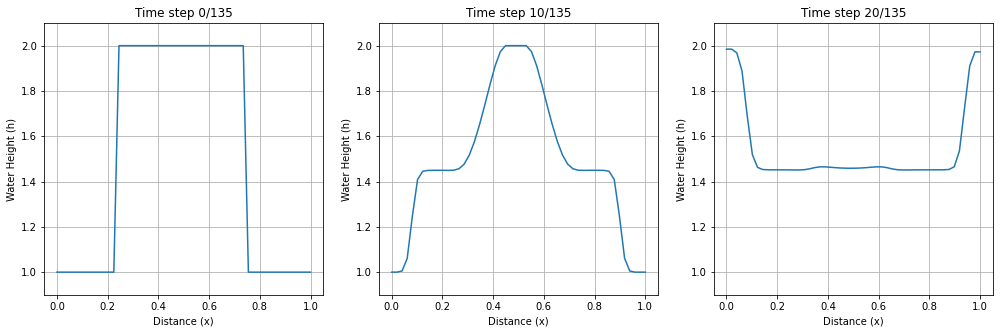

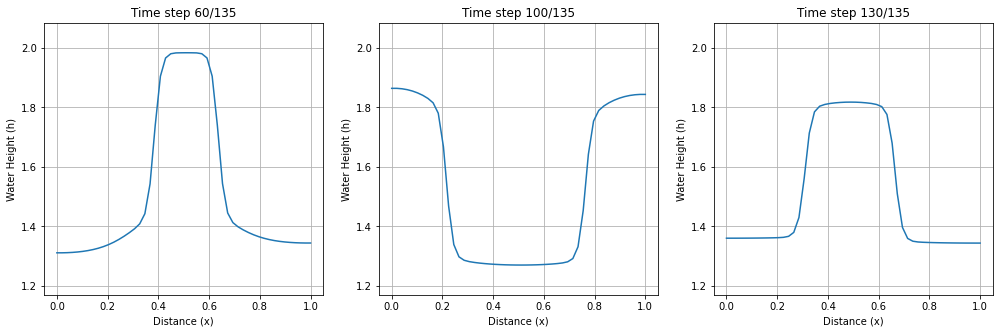

In [50]:
# Initialization
N = 50 # Number of grid points
L = 1 # Length of the domain

dx = L / N
x = np.linspace(0, L, N)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

t = 0
t_end = 0.5

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, lim_func = no_limiter, CFL=0.9,g=9.81)

#subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/solution.png')
n = len(h_hist)
#idx = [0, int(n/2), n-1]
idx = [0, 10, 20]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter.png')
idx = [60, 100, 130]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter_2.png')


In [51]:
if 0:    
    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')
        ax.set_ylim(0, 2.1)  # Adjust this based on the expected range of water height
        ax.set_xlim(0, L)     # Ensure x-axis limits are consistent

    # Create animation
    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

    # Display the animation
    HTML(ani.to_jshtml())


In [52]:
#ani.save('animation_24062024.html', writer='html')
#dpi = 200
#ani.save('animation_24062024.gif', writer='pillow', dpi = dpi)

## Validate with solution

### No limiter

Number of time steps: 79


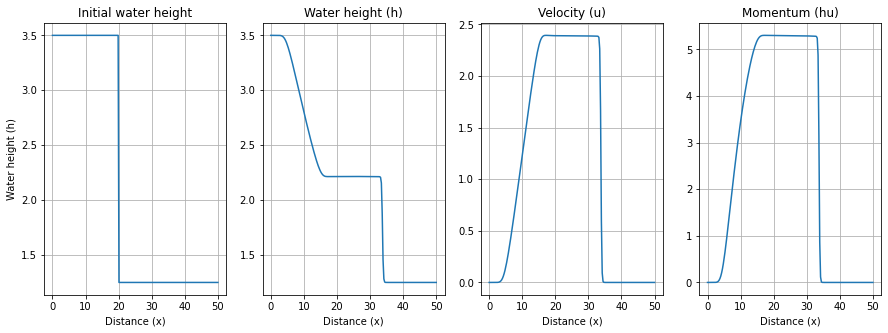

In [53]:
# Initialization
N = 200 # Number of grid points
L = 50 # Length of the domain
dx = L / N
x = np.linspace(0, L, N)

# Initial conditions
l = 2*np.pi
A = 1
T = 2*np.pi
omega = 2*np.pi/T
k = 2*np.pi/l
g = 9.81
h0 = omega**2/(k**2*g)

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 2.5

def eta_func(x,t):
    return A*np.cos(omega*t - k*x)

def u_func(x,t):
    return omega/(k*h0)*eta_func(x,t)

def no_limiter(a, b):
    return 0

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, lim_func = no_limiter, CFL=0.9,g=9.81)

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/sol_1D_val_no_limiter.png')


### Add limiter

Number of time steps: 79


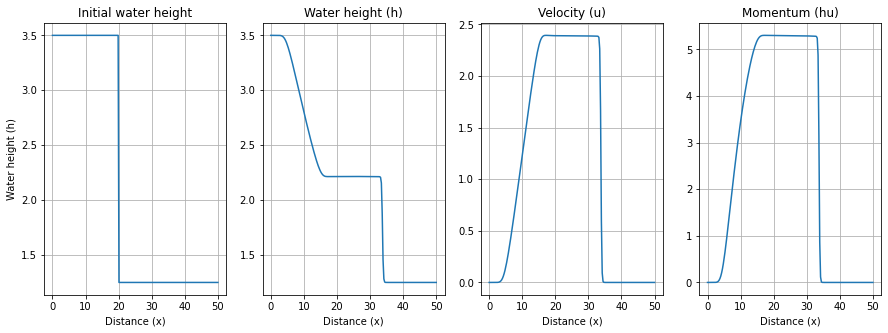

In [54]:
# Initialization
N = 200 # Number of grid points
L = 50 # Length of the domain
dx = L / N

# Initial conditions
l = 2*np.pi
A = 1
T = 2*np.pi
omega = 2*np.pi/T
k = 2*np.pi/l
g = 9.81
h0 = omega**2/(k**2*g)

x = np.linspace(0, L, N)

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 2.5

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, lim_func = minmod, CFL=0.9,g=9.81)

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/sol_1d_val_limiter.png')


In [55]:
if 0:    
    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')
        ax.set_ylim(0, 3.6)  # Adjust this based on the expected range of water height
        ax.set_xlim(0, L)     # Ensure x-axis limits are consistent
        ax.grid(True)
        
    # Create animation
    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

    # Display the animation
    HTML(ani.to_jshtml())


In [56]:
# Save animation as a gif
#ani.save('animation_18062024.html', writer='html')
#dpi = 200
#ani.save('animation_18062024.gif', writer='pillow', dpi = dpi)

## Pyro SWE

In [57]:
import pyro
from pyro.mesh import patch, boundary as bnd, array_indexer as ai, fv
from pyro.swe import simulation as sim
from pyro.util import msg

In [58]:
# Set up the simulation parameters
Nx = 10
Ny = 10
Lx = 1.0
Ly = 1.0
dx = Lx / Nx
dy = Ly / Ny
CFL = 0.9
g = 9.81

# Time parameters
t = 0.0
t_end = 1.0

# Create the grid
myg = patch.Grid2d(Nx, Ny, xmax=dx, ymax=dy)
myd = patch.CellCenterData2d(myg)

bc = bnd.BC(xlb="periodic", xrb="periodic", ylb="reflect-even", yrb="outflow")

# Initial conditions
h = np.ones((Nx, Ny))
hu = np.zeros((Nx, Ny))
hv = np.zeros((Nx, Ny)) 
h[:Nx//2, :Ny//2] = 2.0 # Dam break problem 

# Register variables and apply boundary conditions
myd.register_var('h', bc)
myd.register_var('hu', bc)
myd.register_var('hv', bc)
myd.create()

# Create the SWE solver
problem_name = "shallow_water"
rp = None  # You can provide a Riemann solver if needed

solver = sim.Simulation(myd, problem_name, rp)



In [59]:
solver

In [60]:
#from pyro import riemann
#rp = riemann.hllc

In [61]:
solver.dt


-1e+33

In [62]:
import pyro.swe.simulation as sim
print(dir(sim.Simulation))
print(dir(solver))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compute_timestep', 'do_output', 'dovis', 'evolve', 'finalize', 'finished', 'initialize', 'method_compute_timestep', 'preevolve', 'read_extras', 'write', 'write_extras']
['SMALL', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'cc_data', 'cm', 'compute_timestep', 'data_class', 'do_output', 'dovis', 'dt', 'dt_old', 'evolve', 'finalize', 'finished', 'initial

## Pyro Dam 

In [63]:
from pyro.pyro_sim import Pyro
solver = "swe"

problem_name = "dam"
param_file = "inputs.dam.x"
other_commands = ["driver.max_steps=1", "driver.tmax = 1", "mesh.nx=8",  "mesh.ny=8"]


pyro ...
warning, key: driver.tmax  not defined
initializing the dam problem...
cc data: nx = 8, ny = 8, ng = 4
         nvars = 4
         variables:
          height: min:    0.1250000000    max:    1.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-even +y: reflect-even
      x-momentum: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-even +y: reflect-even
      y-momentum: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-odd  +y: reflect-odd 
            fuel: min:    0.0000000000    max:    1.0000000000
                  BCs: -x: outflow      +x: outflow      -y: reflect-even +y: reflect-even



c:\ProgramData\Anaconda3\lib\site-packages\pyro\swe\simulation.py:260: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cb = axes.cbar_axes[n].colorbar(img)
c:\ProgramData\Anaconda3\lib\site-packages\pyro\swe\simulation.py:260: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  cb = axes.cbar_axes[n].colorbar(img)


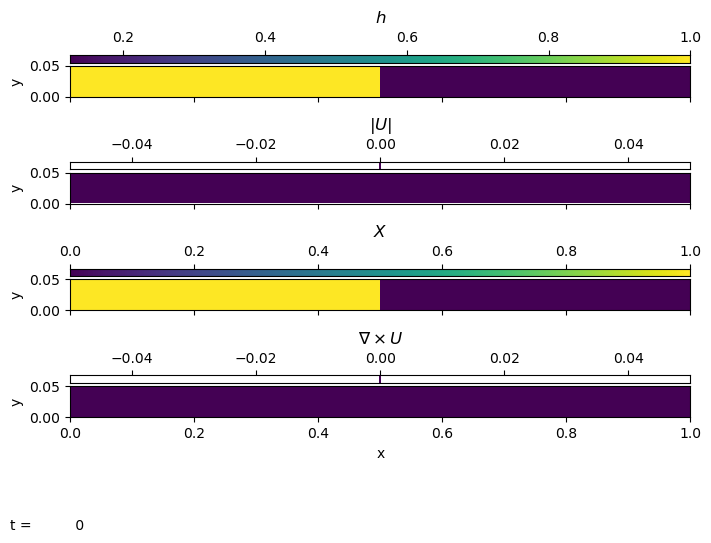

    1    0.00005    0.00005


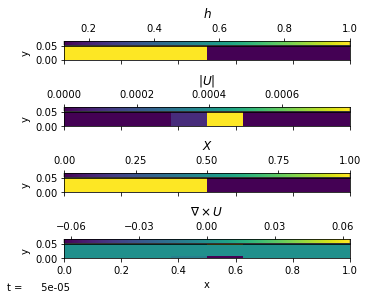

outputting...
parameter particles.n_particles never used
parameter particles.particle_generator never used
parameter swe.cvisc never used
main:  6.343178749084473
   evolve:  0.014461040496826172
      unsplitFluxes:  0.013426780700683594
         limiting:  0.0
         interfaceStates:  0.00630950927734375
         riemann:  0.007117271423339844
         transverse flux addition:  0.0
   vis:  3.2107326984405518

          The script analysis/dam_compare.py can be used to compare
          this output to the exact solution.
          


<Figure size 432x288 with 0 Axes>

In [64]:
pyro_sim = Pyro(solver)
pyro_sim.initialize_problem(problem_name, param_file, other_commands=other_commands)
pyro_sim.run_sim()

In [65]:
hu = pyro_sim.sim.cc_data.get_var("x-momentum")
hu = np.array(hu)

hv = pyro_sim.sim.cc_data.get_var("y-momentum")
hv = np.array(hv)

In [66]:
h = pyro_sim.sim.cc_data.get_var('height')
h = np.array(h)
h.shape

(16, 16)

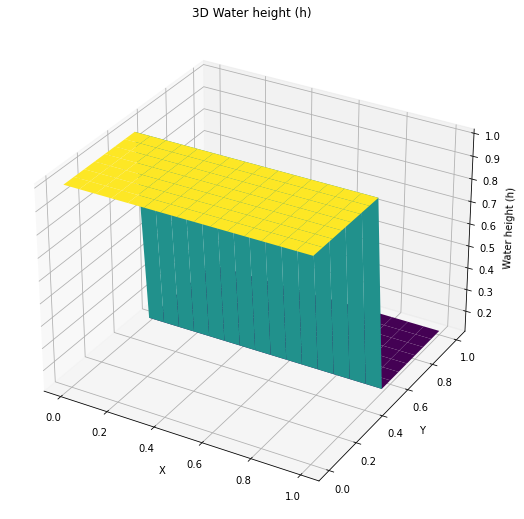

In [67]:
# Make x and y meshgrid
L = 1
x = np.linspace(0, L, 16)
y = np.linspace(0, L, 16)
x, y = np.meshgrid(x, y)

# Plot h
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, h, cmap='viridis')

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Water height (h)')
ax.set_title('3D Water height (h)')
plt.show()

## Solve the 2D SWE

In [68]:
def roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g=9.81, lim_func = no_limiter):
    # Calculate Roe averages
    h_tilde = (hL + hR) / 2
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))
    v_tilde = (np.sqrt(hL) * hvL / hL + np.sqrt(hR) * hvR / hR) / (np.sqrt(hL) + np.sqrt(hR))
    c = np.sqrt(g * h_tilde)

    # Calculate eigenvalues (x-direction)
    lambda1_x = u_tilde - c
    lambda2_x = u_tilde
    lambda3_x = u_tilde + c

    # Calculate eigenvalues (y-direction)
    lambda1_y = v_tilde - c
    lambda2_y = v_tilde
    lambda3_y = v_tilde + c

    # Compute fluxes (x-direction)
    F_L = np.array([huL, huL**2 / hL + 0.5 * g * hL**2, huL*hvL/hL])
    F_R = np.array([huR, huR**2 / hR + 0.5 * g * hR**2, huR*hvR/hR])

    # Compute fluxes (y-direction)
    G_L = np.array([huL, huL*hvL/hL, hvL**2/hL + 0.5*g*hL**2])
    G_R = np.array([huR, huR*hvR/hR, hvR**2/hR + 0.5*g*hR**2])

    # Difference in conserved variables
    dU = np.array([hR - hL, huR - huL, hvR - hvL])

    # Compute wave strengths
    alpha1_x = (lambda3_x * dU[0] - dU[1]) / (2 * c)
    alpha2_x = (dU[2] - v_tilde * dU[0]) 
    alpha3_x = (- lambda1_x * dU[0] + dU[1]) / (2 * c)

    alpha1_y = (lambda3_y * dU[0] - dU[2]) / (2 * c)
    alpha2_y = (dU[1] - u_tilde * dU[0]) 
    alpha3_y = (-lambda1_y * dU[0] + dU[2]) / (2 * c)
    
    # Compute Roe fluxes
    #flux_x = 0.5* (F_L + F_R) - 0.5 * np.array([alpha1_x * abs(lambda1_x), alpha2_x * abs(lambda2_x), alpha3_x * abs(lambda3_x)]) 
    #flux_y = 0.5* (G_L + G_R) - 0.5 * np.array([alpha1_y * abs(lambda1_y), alpha2_y * abs(lambda2_y), alpha3_y * abs(lambda3_y)])
    flux_x = 0.5* (F_L + F_R) - 0.5 * c * dU * np.sign(lambda2_x)
    flux_y = 0.5* (G_L + G_R) - 0.5 * c * dU * np.sign(lambda2_y)

    limiter = lim_func(hL, hR)
    flux_x -= limiter 
    flux_y -= limiter
    
    return flux_x, flux_y


In [69]:
from Riemann import *


ModuleNotFoundError: No module named 'Riemann'

In [ ]:
def compute_interface_fluxes_2D(h, hu, hv, Nx, Ny, g, lim_func = no_limiter):
    fluxes_x = np.zeros((3, Nx+1, Ny))
    fluxes_y = np.zeros((3, Nx, Ny+1))
    
    # Compute fluxes in x-direction
    for j in range(Ny):
        # Apply boundary conditions at the walls
        hL, huL, hvL = h[0, j], -hu[0,j], hv[0,j] # Reflective boundary at x=0
        hR, huR, hvR = h[1, j], hu[1,j], hv[1,j]
        fluxes_x[:, 0, j], _ = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g, lim_func)
        ul = huL/hL
        ur = huR/hR
        vl = hvL/hL
        vr = hvR/hR
        dl = L / Nx
        dr = dl
        F1, F2, F3, hs = CalcRiemannFlux(hL,hR,huL,huR,hvL,hvR,ul,ur,vl,vr,dl,dr,g,Nx,Ny,l,tol = 1e-6)

        for i in range(1, Nx):
            fluxes_x[:, i, j], _ = roe_solver_2D(h[i-1, j], hu[i-1, j], hv[i-1, j], h[i, j], hu[i, j], hv[i, j], g, lim_func)

        hL, huL, hvL = h[Nx-2, j], hu[Nx-2, j], hv[Nx-2, j]
        hR, huR, hvR = h[Nx-1, j], -hu[Nx-1,j], hv[Nx-1, j] # Reflective boundary at x=L
        fluxes_x[:, Nx, j], _ = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g, lim_func)

    # Compute fluxes in y-direction
    for i in range(Nx):
        # Apply boundary conditions at the walls
        hL, huL, hvL = h[i, 0], hu[i, 0], -hv[i, 0] # Reflective boundary at y=0
        hR, huR, hvR = h[i, 1], hu[i, 1], hv[i, 1]
        _, fluxes_y[:, i, 0] = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g, lim_func)

        for j in range(1, Ny):
            _, fluxes_y[:, i, j] = roe_solver_2D(h[i, j-1], hu[i, j-1], hv[i, j-1], h[i, j], hu[i, j], hv[i, j], g, lim_func)

        hL, huL, hvL = h[i, Ny-2], hu[i, Ny-2], hv[i, Ny-2]
        hR, huR, hvR = h[i, Ny-1], hu[i, Ny-1], -hv[i, Ny-1] # Reflective boundary at y=L
        _, fluxes_y[:, i, Ny] = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g, lim_func)
    
    return fluxes_x, fluxes_y

In [ ]:
def update_variables_2D(h, hu, hv, dt, fluxes_x, fluxes_y, Nx, Ny, dx, dy):
    h_new = h.copy()
    hu_new = hu.copy()
    hv_new = hv.copy()

    # Update variables in x-direction
    for i in range(1, Nx-1):
        for j in range(Ny):
            h_new[i, j] -= dt/dx * (fluxes_x[0, i+1, j] - fluxes_x[0, i, j])
            hu_new[i, j] -= dt/dx * (fluxes_x[1, i+1, j] - fluxes_x[1, i, j])
            hv_new[i, j] -= dt/dx * (fluxes_x[2, i+1, j] - fluxes_x[2, i, j])

    # Update variables in y-direction
    for i in range(Nx):
        for j in range(1, Ny-1):
            h_new[i, j] -= dt/dy * (fluxes_y[0, i, j+1] - fluxes_y[0, i, j])
            hu_new[i, j] -= dt/dy * (fluxes_y[1, i, j+1] - fluxes_y[1, i, j])
            hv_new[i, j] -= dt/dy * (fluxes_y[2, i, j+1] - fluxes_y[2, i, j])

    # Apply reflective boundary conditions
    h_new[0, :] = h_new[1, :]
    hu_new[0, :] = -hu_new[1, :]
    hv_new[0, :] = hv_new[1, :]

    h_new[Nx-1, :] = h_new[Nx-2, :]
    hu_new[Nx-1, :] = -hu_new[Nx-2, :]
    hv_new[Nx-1, :] = hv_new[Nx-2, :]

    h_new[:, 0] = h_new[:, 1]
    hu_new[:, 0] = hu_new[:, 1]
    hv_new[:, 0] = -hv_new[:, 1]

    h_new[:, Ny-1] = h_new[:, Ny-2]
    hu_new[:, Ny-1] = hu_new[:, Ny-2]
    hv_new[:, Ny-1] = -hv_new[:, Ny-2]
    
    return h_new, hu_new, hv_new

In [ ]:
# putting it all together
def solve_SWE_2D(t, t_end, h, hu, hv, Nx, Ny, dx, dy,CFL=0.9,g=9.81, lim_func = no_limiter):
    # Store the intermediate states
    h_hist = []
    hu_hist = []
    hv_hist = []
    dt_hist = []

    h_hist.append(h.copy())
    hu_hist.append(hu.copy())
    hv_hist.append(hv.copy())

    # Main loop
    while t < t_end:
        # Compute the time step
        u = hu/h
        v = hv/h
        c = np.sqrt(g*h)
        dt = CFL * dx/np.max(np.abs(u) + c)

        if t + dt > t_end:
            dt = t_end - t
        
        # Compute the fluxes at the interfaces
        fluxes_x, fluxes_y = compute_interface_fluxes_2D(h, hu, hv, Nx, Ny, g, lim_func)

        # Update the variables
        h, hu, hv = update_variables_2D(h, hu, hv, dt, fluxes_x, fluxes_y, Nx, Ny, dx, dy)

        # Store the results
        h_hist.append(h.copy())
        hu_hist.append(hu.copy())
        hv_hist.append(hv.copy())
        dt_hist.append(dt)

        # Update the time
        t += dt

    n = len(dt_hist)

    print(f"Number of time steps: {n}")

    return h, h_hist, hu, hv

In [ ]:
# Initialization
N = 10 # Number of grid points
Nx = N
Ny = N

L = 0.1
Lx = L # Length of the domain in x-direction
Ly = L # Length of the domain in y-direction

dx = L / Nx
dy = L / Ny

x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

t = 0
t_end = 1

# Initial conditions
h = np.ones((Nx, Ny))
hu = np.zeros((Nx, Ny))
hv = np.zeros((Nx, Ny))

# Set the initial water height (dam break problem)
h[:int(Nx/2), :int(Ny/2)] = 2.0  # higher water level in the corner


h, h_hist, hu, hv = solve_SWE_2D(t, t_end, h, hu, hv, Nx, Ny, dx, dy,CFL=0.9,g=9.81, lim_func=no_limiter)


TypeError: 'numpy.float64' object does not support item assignment

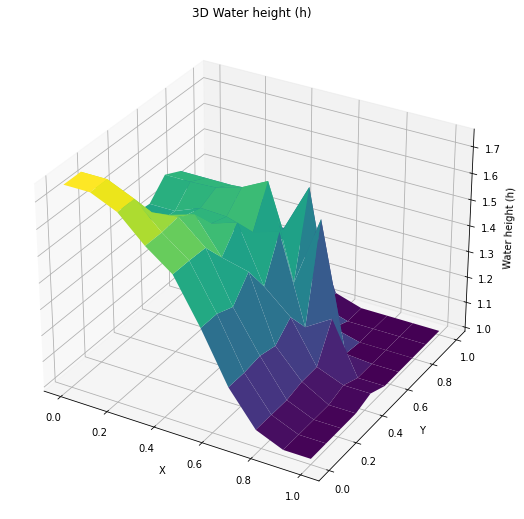

In [ ]:
# Make x and y meshgrid
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
x, y = np.meshgrid(x, y)

# Plot h
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, h_hist[5], cmap='viridis')

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Water height (h)')
ax.set_title('3D Water height (h)')
plt.show()



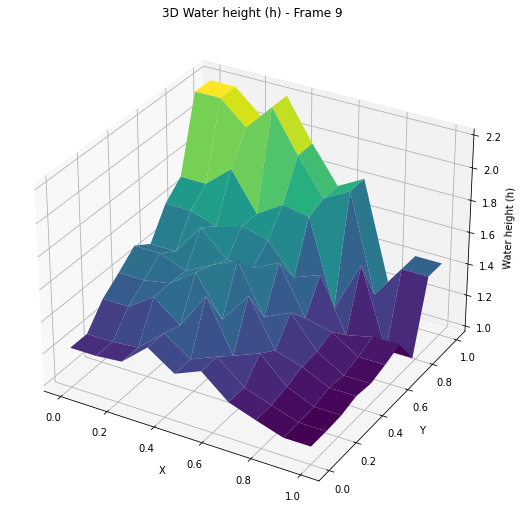

In [ ]:
# Create figure and 3D axis
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

# Function to update the surface plot
def update_plot(frame):
    ax.clear()
    surf = ax.plot_surface(x, y, h_hist[frame], cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Water height (h)')
    ax.set_title(f'3D Water height (h) - Frame {frame}')
    return surf,

# Create the animation
ani = FuncAnimation(fig, update_plot, frames=10, interval=200)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())
